# 🎧 NeuroLoop: Spotify Listening Behavior Analysis

This project analyzes recently played Spotify tracks using Spotipy to detect behavioral replay patterns and predict high-replay moments ("dopamine hits").

Key features:
- Spotify API integration
- Data cleaning and feature engineering
- Replay pattern detection
- ML classification model to predict replays
- Visualizations of trends and model outputs


In [9]:
from dotenv import load_dotenv
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

# Load environment variables (API keys)
load_dotenv()


True

In [10]:
from dotenv import load_dotenv
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

load_dotenv()


True

⚠️ Make sure to store your Spotify keys in a `.env` file and **never upload that file to GitHub**.


In [11]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth

sp = spotipy.Spotify(auth_manager=SpotifyOAuth(
    client_id=os.getenv("SPOTIPY_CLIENT_ID"),
    client_secret=os.getenv("SPOTIPY_CLIENT_SECRET"),
    redirect_uri=os.getenv("SPOTIPY_REDIRECT_URI"),
    scope="user-read-recently-played"
))


In [12]:
recent_tracks = sp.current_user_recently_played(limit=50)

track_data = []
for item in recent_tracks['items']:
    track = item['track']
    track_data.append({
        'name': track['name'],
        'artist': track['artists'][0]['name'],
        'played_at': item['played_at']
    })

df = pd.DataFrame(track_data)
df['played_at'] = pd.to_datetime(df['played_at'])
df['date'] = df['played_at'].dt.date
df['hour'] = df['played_at'].dt.hour
df['day_of_week'] = df['played_at'].dt.day_name()


In [13]:
# Count how many times a track was played on the same day
rewind_counts = df.groupby(['name', 'date']).size().reset_index(name='rewind_score')
df = df.merge(rewind_counts, on=['name', 'date'], how='left')

# Label high-replay tracks
df['is_high_replay'] = df['rewind_score'] >= 3


In [14]:
df.to_csv("recent_tracks_behavior_only.csv", index=False)


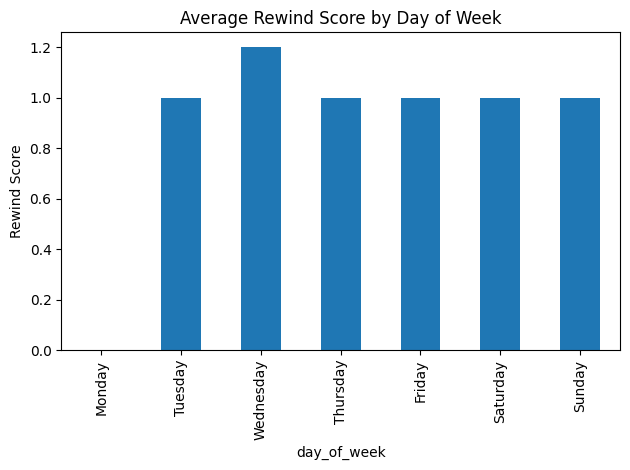

In [15]:
# Average rewind score by day
df_summary = df.groupby('day_of_week')['rewind_score'].mean().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

df_summary.plot(kind='bar', title='Average Rewind Score by Day of Week')
plt.ylabel('Rewind Score')
plt.tight_layout()
plt.show()


In [18]:
plt.savefig('rewind_by_day.png')


<Figure size 640x480 with 0 Axes>

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X = df[['hour', 'day_of_week', 'artist']]
y = df['is_high_replay'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), ['day_of_week', 'artist'])],
    remainder='passthrough'
)

clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



In [ ]:
importances = clf.named_steps['classifier'].feature_importances_
feature_names = clf.named_steps['preprocessor'].get_feature_names_out()
feat_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_df.head(10))
plt.title('Top 10 Features Predicting Replays')
plt.tight_layout()
plt.savefig('visuals/top_features.png')
plt.show()


## ✅ Summary

In this project, I:
- Collected live Spotify listening data
- Engineered features like hour, day, and replay score
- Used data visualization to uncover trends
- Built a Random Forest model to predict high-replay tracks
- Analyzed feature importances

**Next steps**:
- Turn this into an interactive dashboard (Streamlit)
- Add genre or mood-based features
